In [1]:
import os
import sys
import datetime as dt
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import mlflow
import json
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import itertools
from tqdm import tqdm
import inspect
import matplotlib.pyplot as plt
import seaborn as sns


for m in [pd, tf, tfa, mlflow]:
    print(f"{m.__name__:20s}\t{m.__version__}")

# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

tf.config.experimental.enable_tensor_float_32_execution(enabled=True)

OUTPUTPATH = "/mnt/workdata/_WORK_/mail_zonning/mail_zoning/sandbox/"
DATAPATH = "/mnt/workdata/_WORK_/mail_zonning/mail_zoning/dataset/enron_files_annotated/"
FILESTORE = "/mnt/workdata/_WORK_/mail_zonning/mail_zoning/tmp/"
MLFLOW_DIR = "file:///mnt/workdata/_WORK_/mail_zonning/mail_zoning/mlruns/"
TENSORBOARD_DIR = '/mnt/workdata/_WORK_/mail_zonning/mail_zoning/optim/sequenced_bilstm/tblogs/'
ENAME = 'SEQUENCED_CBiGRU_iter_0'

BOM_SIGNAL = 'the start of the email signal, no lines before'
EOM_SIGNAL = 'the end of the email signal, no lines after'




pandas              	1.5.0
tensorflow          	2.9.2
tensorflow_addons   	0.18.0
mlflow              	1.29.0


In [2]:
sys.path.append("/mnt/workdata/_WORK_/mail_zonning/mail_zoning/sandbox/")
from sentence_classifier import SentenceClassifier

In [3]:
def prepare_dataset(datapath: str):
    def extract_text(text, flags: dict):
        text = text.split('\n')
        idx = 0
        while text[idx][:2] not in flags:
            idx += 1
        labels = [flags[t[:2]] for t in text[idx:] if len(t) > 1]
        text = [t[2:] for t in text[idx:]]
        return text, labels

    # load and extract flag data
    FLAGS = {'B>': 0, 'H>': 1, 'S>': 2}
    files = {}
    for filename in os.listdir(datapath):
        with open(os.path.join(datapath, filename), 'rt') as f:
            files[filename] = f.read()
    _ = []
    for filename in files.keys():
        text_ = files[filename]
        textlines, labels = extract_text(text_, FLAGS)
        for idx, line_label in enumerate(zip(textlines, labels)):
            _.append({'doc': filename, 'idx': idx, 'sentence': line_label[0], 'label': line_label[1]})
    df = pd.DataFrame.from_dict(_)
    return df

def split_dataset(data: pd.DataFrame, random_state: int):
    """"
    Dataset split is based on complete emails, not on email lines
    """
    splitter = KFold(n_splits=5, shuffle=True, random_state=random_state)
    docs = data['doc'].unique()
    splits = splitter.split(docs)
    train_data = []
    val_data = []
    for train_idx, val_idx in splits:
        train_data_ = data.loc[data['doc'].isin(docs[train_idx])]
        train_data.append(train_data_[['doc', 'idx', 'sentence', 'label']])
        val_data_ = data.loc[data['doc'].isin(docs[val_idx])]
        val_data.append(val_data_[['doc', 'idx', 'sentence', 'label']])
    return train_data, val_data

## Window size = 3

In [4]:
model_params = {
    "output_class_count": 3,
    "vocab_size": 8000,
    "output_sequence_length": 45,
    "embedding_dimension": 150,
    "window_size": 3,
    "conv1d_0_units": 80,
    "conv1d_0_kernelsize": 3,
    "conv1d_0_padding": "valid",
    "conv1d_0_activation": "relu",
    "conv1d_1_units": 80,
    "conv1d_1_kernelsize": 3,
    "conv1d_1_padding": "valid",
    "conv1d_1_activation": "relu",
    "gru_0_units": 128,
    "gru_1_units": 64,
    "drop_0_rate": 0.3448836829019953,
    "initial_lr": 0.0006500000000000001,
    "lr_reduction_factor": 0.44531593652922397,
    "lr_reduction_patience": 3,
    "batch_size": 56,
    "max_epochs": 100,
    "early_stop_patience": 10
}

In [5]:
RANDOM_STATE=123
df = prepare_dataset(DATAPATH)
train_subsets, val_subsets = split_dataset(df, RANDOM_STATE)

texts = df['sentence'].values

In [6]:
results={}
for idx in range(len(train_subsets)):
    tf.keras.backend.clear_session()
    clf=SentenceClassifier(
        model_params=model_params,
        bod_line = 'This is the first line of document. No lines come before.',
        eod_line='This is the last line of document. No lines come after.',
        corpus=texts)
    clf.prepare_train_records(data=train_subsets[idx])
    clf.prepare_validation_records(data=val_subsets[idx])
    clf.compile(optimizer=tf.keras.optimizers.Adam(model_params['initial_lr']),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    clf.fit(
            x=clf.train_texts, y=clf.train_labels,
            batch_size=model_params['batch_size'],
            epochs=model_params['max_epochs'],
            validation_data=(clf.validation_texts, clf.validation_labels),
            use_multiprocessing=True,
            callbacks=[
                tf.keras.callbacks.ReduceLROnPlateau(
                    factor=model_params['lr_reduction_factor'], patience=model_params['lr_reduction_patience'], verbose=0),
                tf.keras.callbacks.EarlyStopping(
                    min_delta=1e-4, patience=model_params['early_stop_patience'], restore_best_weights=True)
            ],verbose=1)
    results[idx]=clf.evaluate(clf.validation_texts, clf.validation_labels)


2022-12-03 23:11:21.268492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 23:11:21.275478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 23:11:21.275709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 23:11:21.276351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100


2022-12-03 23:11:26.664605: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-12-03 23:11:27.108471: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-03 23:11:27.750080: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


196/196 [==============================] - 7s 12ms/step - loss: 0.2656 - accuracy: 0.9034 - val_loss: 0.4067 - val_accuracy: 0.8574 - lr: 6.5000e-04
Epoch 2/100
196/196 [==============================] - 1s 8ms/step - loss: 0.0580 - accuracy: 0.9834 - val_loss: 0.1608 - val_accuracy: 0.9626 - lr: 6.5000e-04
Epoch 3/100
196/196 [==============================] - 1s 7ms/step - loss: 0.0430 - accuracy: 0.9883 - val_loss: 0.0851 - val_accuracy: 0.9799 - lr: 6.5000e-04
Epoch 4/100
196/196 [==============================] - 1s 8ms/step - loss: 0.0321 - accuracy: 0.9904 - val_loss: 0.0635 - val_accuracy: 0.9846 - lr: 6.5000e-04
Epoch 5/100
196/196 [==============================] - 1s 8ms/step - loss: 0.0327 - accuracy: 0.9907 - val_loss: 0.0836 - val_accuracy: 0.9745 - lr: 6.5000e-04
Epoch 6/100
196/196 [==============================] - 1s 8ms/step - loss: 0.0289 - accuracy: 0.9922 - val_loss: 0.0560 - val_accuracy: 0.9835 - lr: 6.5000e-04
Epoch 7/100
196/196 [==============================

In [7]:
master_results={3:results}

## Window size = 5

In [8]:
model_params = {
    "output_class_count": 3,
    "vocab_size": 8000,
    "output_sequence_length": 45,
    "embedding_dimension": 150,
    "window_size": 5,
    "conv1d_0_units": 80,
    "conv1d_0_kernelsize": 3,
    "conv1d_0_padding": "valid",
    "conv1d_0_activation": "relu",
    "conv1d_1_units": 80,
    "conv1d_1_kernelsize": 3,
    "conv1d_1_padding": "valid",
    "conv1d_1_activation": "relu",
    "gru_0_units": 128,
    "gru_1_units": 64,
    "drop_0_rate": 0.3448836829019953,
    "initial_lr": 0.0006500000000000001,
    "lr_reduction_factor": 0.44531593652922397,
    "lr_reduction_patience": 3,
    "batch_size": 56,
    "max_epochs": 100,
    "early_stop_patience": 10
}

In [9]:
RANDOM_STATE=123
df = prepare_dataset(DATAPATH)
train_subsets, val_subsets = split_dataset(df, RANDOM_STATE)

texts = df['sentence'].values

In [10]:
results={}
for idx in range(len(train_subsets)):
    tf.keras.backend.clear_session()
    clf=SentenceClassifier(
        model_params=model_params,
        bod_line = 'This is the first line of document. No lines come before.',
        eod_line='This is the last line of document. No lines come after.',
        corpus=texts)
    clf.prepare_train_records(data=train_subsets[idx])
    clf.prepare_validation_records(data=val_subsets[idx])
    clf.compile(optimizer=tf.keras.optimizers.Adam(model_params['initial_lr']),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    clf.fit(
            x=clf.train_texts, y=clf.train_labels,
            batch_size=model_params['batch_size'],
            epochs=model_params['max_epochs'],
            validation_data=(clf.validation_texts, clf.validation_labels),
            use_multiprocessing=True,
            callbacks=[
                tf.keras.callbacks.ReduceLROnPlateau(
                    factor=model_params['lr_reduction_factor'], patience=model_params['lr_reduction_patience'], verbose=0),
                tf.keras.callbacks.EarlyStopping(
                    min_delta=1e-4, patience=model_params['early_stop_patience'], restore_best_weights=True)
            ],verbose=1)
    results[idx]=clf.evaluate(clf.validation_texts, clf.validation_labels)


Epoch 1/100
196/196 [==============================] - 6s 13ms/step - loss: 0.2232 - accuracy: 0.9159 - val_loss: 0.4076 - val_accuracy: 0.8376 - lr: 6.5000e-04
Epoch 2/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0403 - accuracy: 0.9873 - val_loss: 0.0953 - val_accuracy: 0.9795 - lr: 6.5000e-04
Epoch 3/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0219 - accuracy: 0.9937 - val_loss: 0.0387 - val_accuracy: 0.9896 - lr: 6.5000e-04
Epoch 4/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0129 - accuracy: 0.9962 - val_loss: 0.0207 - val_accuracy: 0.9932 - lr: 6.5000e-04
Epoch 5/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0119 - accuracy: 0.9965 - val_loss: 0.0342 - val_accuracy: 0.9881 - lr: 6.5000e-04
Epoch 6/100
196/196 [==============================] - 2s 8ms/step - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.0431 - val_accuracy: 0.9889 - lr: 6.5000e-04
Epoch 7/100
196/196 [==================

In [11]:
master_results[5]=results

## Window size = 7

In [12]:
model_params = {
    "output_class_count": 3,
    "vocab_size": 8000,
    "output_sequence_length": 45,
    "embedding_dimension": 150,
    "window_size": 7,
    "conv1d_0_units": 80,
    "conv1d_0_kernelsize": 3,
    "conv1d_0_padding": "valid",
    "conv1d_0_activation": "relu",
    "conv1d_1_units": 80,
    "conv1d_1_kernelsize": 3,
    "conv1d_1_padding": "valid",
    "conv1d_1_activation": "relu",
    "gru_0_units": 128,
    "gru_1_units": 64,
    "drop_0_rate": 0.3448836829019953,
    "initial_lr": 0.0006500000000000001,
    "lr_reduction_factor": 0.44531593652922397,
    "lr_reduction_patience": 3,
    "batch_size": 56,
    "max_epochs": 100,
    "early_stop_patience": 10
}

In [13]:
RANDOM_STATE=123
df = prepare_dataset(DATAPATH)
train_subsets, val_subsets = split_dataset(df, RANDOM_STATE)

texts = df['sentence'].values

In [14]:
results={}
for idx in range(len(train_subsets)):
    tf.keras.backend.clear_session()
    clf=SentenceClassifier(
        model_params=model_params,
        bod_line = 'This is the first line of document. No lines come before.',
        eod_line='This is the last line of document. No lines come after.',
        corpus=texts)
    clf.prepare_train_records(data=train_subsets[idx])
    clf.prepare_validation_records(data=val_subsets[idx])
    clf.compile(optimizer=tf.keras.optimizers.Adam(model_params['initial_lr']),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    clf.fit(
            x=clf.train_texts, y=clf.train_labels,
            batch_size=model_params['batch_size'],
            epochs=model_params['max_epochs'],
            validation_data=(clf.validation_texts, clf.validation_labels),
            use_multiprocessing=True,
            callbacks=[
                tf.keras.callbacks.ReduceLROnPlateau(
                    factor=model_params['lr_reduction_factor'], patience=model_params['lr_reduction_patience'], verbose=0),
                tf.keras.callbacks.EarlyStopping(
                    min_delta=1e-4, patience=model_params['early_stop_patience'], restore_best_weights=True)
            ],verbose=1)
    results[idx]=clf.evaluate(clf.validation_texts, clf.validation_labels)


Epoch 1/100
196/196 [==============================] - 6s 13ms/step - loss: 0.2147 - accuracy: 0.9155 - val_loss: 0.3969 - val_accuracy: 0.8240 - lr: 6.5000e-04
Epoch 2/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0340 - accuracy: 0.9888 - val_loss: 0.1070 - val_accuracy: 0.9608 - lr: 6.5000e-04
Epoch 3/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0196 - accuracy: 0.9935 - val_loss: 0.0209 - val_accuracy: 0.9921 - lr: 6.5000e-04
Epoch 4/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.0269 - val_accuracy: 0.9892 - lr: 6.5000e-04
Epoch 5/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0198 - val_accuracy: 0.9917 - lr: 6.5000e-04
Epoch 6/100
196/196 [==============================] - 2s 9ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0134 - val_accuracy: 0.9957 - lr: 6.5000e-04
Epoch 7/100
196/196 [==================

In [16]:
master_results[7]=results

In [46]:
_={(k,s): {'val_loss':master_results[k][s][0], 'val_accuracy': master_results[k][s][1]}
 for k in master_results.keys() for s in master_results[k].keys()}
_ = pd.DataFrame.from_dict(_).T.reset_index()
_.columns=['window size','split num', 'val loss', 'val accuracy']


In [47]:
_.head()

,window size,split num,val loss,val accuracy
0,3,0,0.055964,0.983477
1,3,1,0.053647,0.983184
2,3,2,0.136493,0.967156
3,3,3,0.069119,0.981271
4,3,4,0.088093,0.979491


(0.9, 1.0)

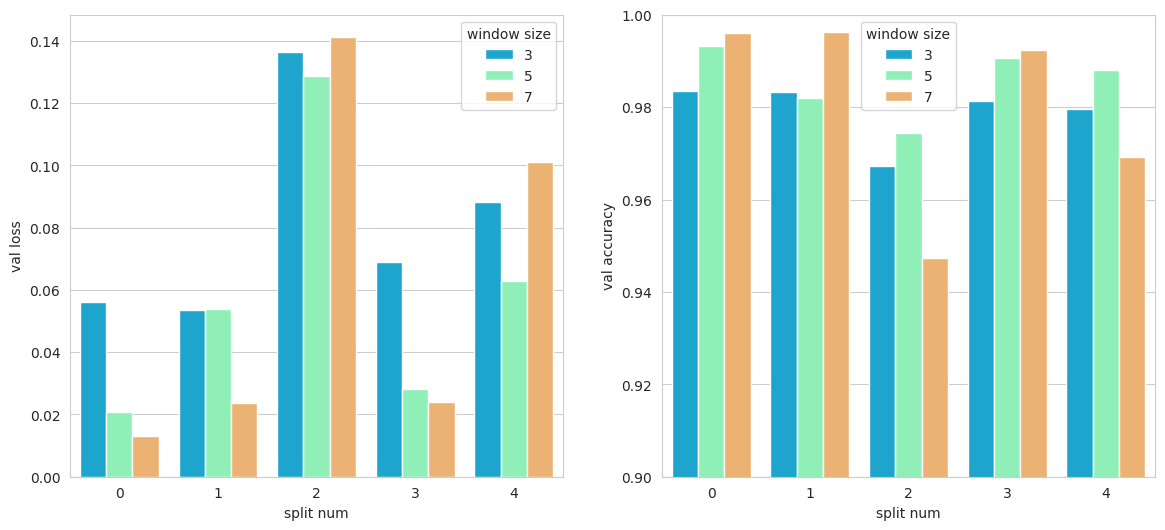

In [66]:
fig, ax=plt.subplots(1,2,figsize=(14,6))
sns.barplot(data=_, x= 'split num', y='val loss', hue='window size',palette='rainbow', ax=ax[0])
sns.barplot(data=_, x= 'split num', y='val accuracy', hue='window size',palette='rainbow', ax=ax[1])
ax[1].set_ylim(0.9, 1.0)

# Testy

In [4]:
model_params = {
    "output_class_count": 3,
    "vocab_size": 8000,
    "output_sequence_length": 45,
    "embedding_dimension": 150,
    "window_size": 2,
    "conv1d_0_units": 80,
    "conv1d_0_kernelsize": 3,
    "conv1d_0_padding": "valid",
    "conv1d_0_activation": "relu",
    "conv1d_1_units": 80,
    "conv1d_1_kernelsize": 3,
    "conv1d_1_padding": "valid",
    "conv1d_1_activation": "relu",
    "gru_0_units": 128,
    "gru_1_units": 64,
    "drop_0_rate": 0.3448836829019953,
    "initial_lr": 0.0006500000000000001,
    "lr_reduction_factor": 0.44531593652922397,
    "lr_reduction_patience": 3,
    "batch_size": 56,
    "max_epochs": 100,
    "early_stop_patience": 10
}


In [5]:
RANDOM_STATE=123
df = prepare_dataset(DATAPATH)
train_subsets, val_subsets = split_dataset(df, RANDOM_STATE)

texts = df['sentence'].values

In [6]:
results={}
for idx in range(len(train_subsets)):
    tf.keras.backend.clear_session()
    clf=SentenceClassifier(
        model_params=model_params,
        bod_line = 'This is the first line of document. No lines come before.',
        eod_line='This is the last line of document. No lines come after.',
        corpus=texts)
    clf.prepare_train_records(data=train_subsets[idx])
    clf.prepare_validation_records(data=val_subsets[idx])
    clf.compile(optimizer=tf.keras.optimizers.Adam(model_params['initial_lr']),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    clf.fit(
            x=clf.train_texts, y=clf.train_labels,
            batch_size=model_params['batch_size'],
            epochs=model_params['max_epochs'],
            validation_data=(clf.validation_texts, clf.validation_labels),
            use_multiprocessing=True,
            callbacks=[
                tf.keras.callbacks.ReduceLROnPlateau(
                    factor=model_params['lr_reduction_factor'], patience=model_params['lr_reduction_patience'], verbose=0),
                tf.keras.callbacks.EarlyStopping(
                    min_delta=1e-4, patience=model_params['early_stop_patience'], restore_best_weights=True)
            ],verbose=1)
    results[idx]=clf.evaluate(clf.validation_texts, clf.validation_labels)


KeyError: 'windo_size'